In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
print("Загрузка CIFAR-10...")
train_dataset = torchvision.datasets.CIFAR10(
    root='/pbabkin/nas-for-moe/code/data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

Загрузка CIFAR-10...
Files already downloaded and verified


In [3]:
split_valid = int(10000)
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.seed(42)
np.random.shuffle(indices)
valid_subset = Subset(train_dataset, indices[split_valid:])
valid_labels = [label for im, label in valid_subset]

# Train VAE

In [4]:
import sys
sys.path.insert(0, '/pbabkin/nas-for-moe/code')
sys.path.insert(0, '/pbabkin/nas-for-moe/code/nas_moe')
import nas_moe.vae
import nas_moe.utils

In [5]:
latent_space = nas_moe.vae.LatentSpace()

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [18]:
# latent_space.train_model(train_dataset, cuda=True, epochs=20)
latent_space.load_checkpoint('/pbabkin/nas-for-moe/code/third_party/Pytorch-VAE/checkpoints/VAE-128k-cifar10-3x32x32')

50

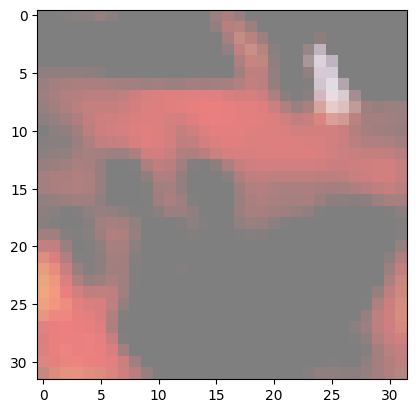

In [22]:
a = train_dataset[5]
plt.imshow(a[0].permute(1, 2, 0).detach())
reconstr = latent_space.reconstruct_image(a[0])
plt.imshow(reconstr[0].permute(1, 2, 0).detach())

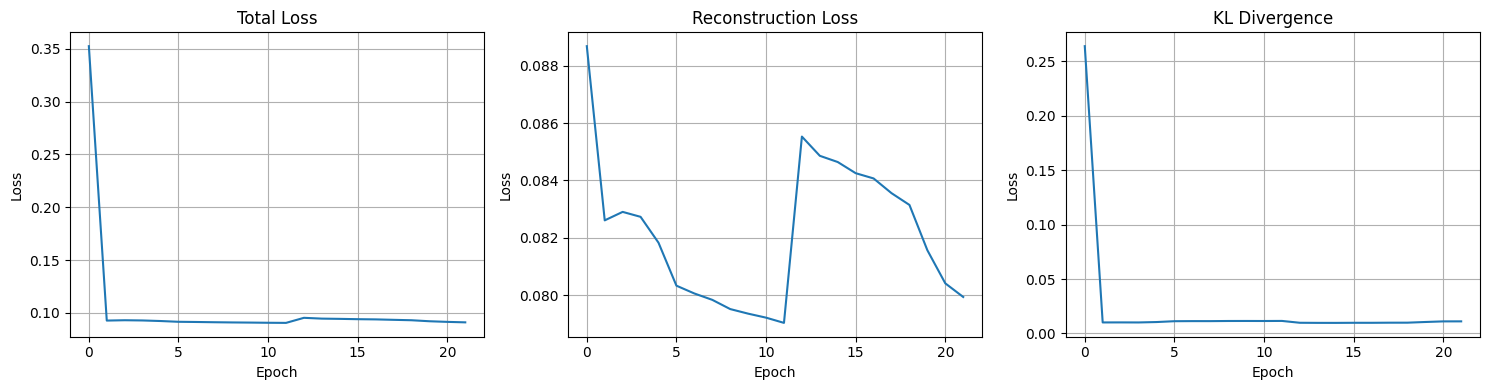

In [18]:
latent_space.plot_training_history()

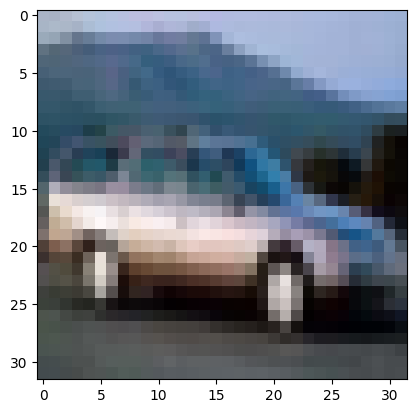

In [24]:
plt.imshow(train_dataset[4][0].permute(1, 2, 0).detach())

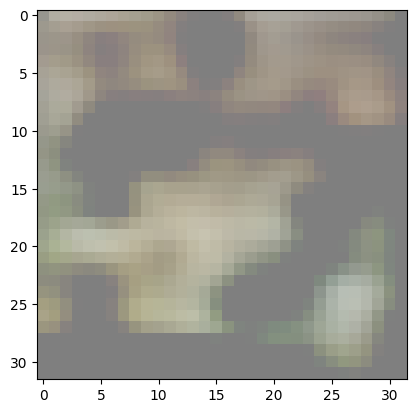

In [25]:
plt.imshow(latent_space.generate()[0].cpu().permute(1, 2, 0).detach().numpy())

# Кластеризация

In [98]:
# Подготовка данных
images = []
labels = []

for img, label in valid_subset:
    z = latent_space.encode_image(img)  # Получаем латентный вектор (тензор)
    images.append(z.cpu().numpy())  # Переводим в numpy

    # img_array = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    # img_flat = img_array.flatten()
    # images.append(img_flat)

    labels.append(label)

# Конвертируем в numpy array
X = np.array(images)
y = np.array(labels)
print(f"Форма данных: {X.shape}")

# 3072 - просто

Форма данных: (40000, 2048)


In [99]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [100]:
# Применяем K-Means кластеризацию
print("Запуск K-Means кластеризации с k=10...")
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10, verbose=0)
kmeans.fit(X_scaled)

# Получаем предсказанные кластеры
clusters = kmeans.labels_

print(f"Кластеризация завершена!")
print(f"Количество уникальных кластеров: {len(np.unique(clusters))}")
print(f"Inertia (сумма квадратов расстояний): {kmeans.inertia_:.2f}")

Запуск K-Means кластеризации с k=10...
Кластеризация завершена!
Количество уникальных кластеров: 10
Inertia (сумма квадратов расстояний): 81314720.00


In [101]:
unique, counts = np.unique(clusters, return_counts=True)
print("\nРаспределение по кластерам:")
for cluster_id, count in zip(unique, counts):
    print(f"  Кластер {cluster_id}: {count} образцов")


Распределение по кластерам:
  Кластер 0: 4131 образцов
  Кластер 1: 3562 образцов
  Кластер 2: 3527 образцов
  Кластер 3: 3553 образцов
  Кластер 4: 3939 образцов
  Кластер 5: 5312 образцов
  Кластер 6: 4791 образцов
  Кластер 7: 3729 образцов
  Кластер 8: 3206 образцов
  Кластер 9: 4250 образцов


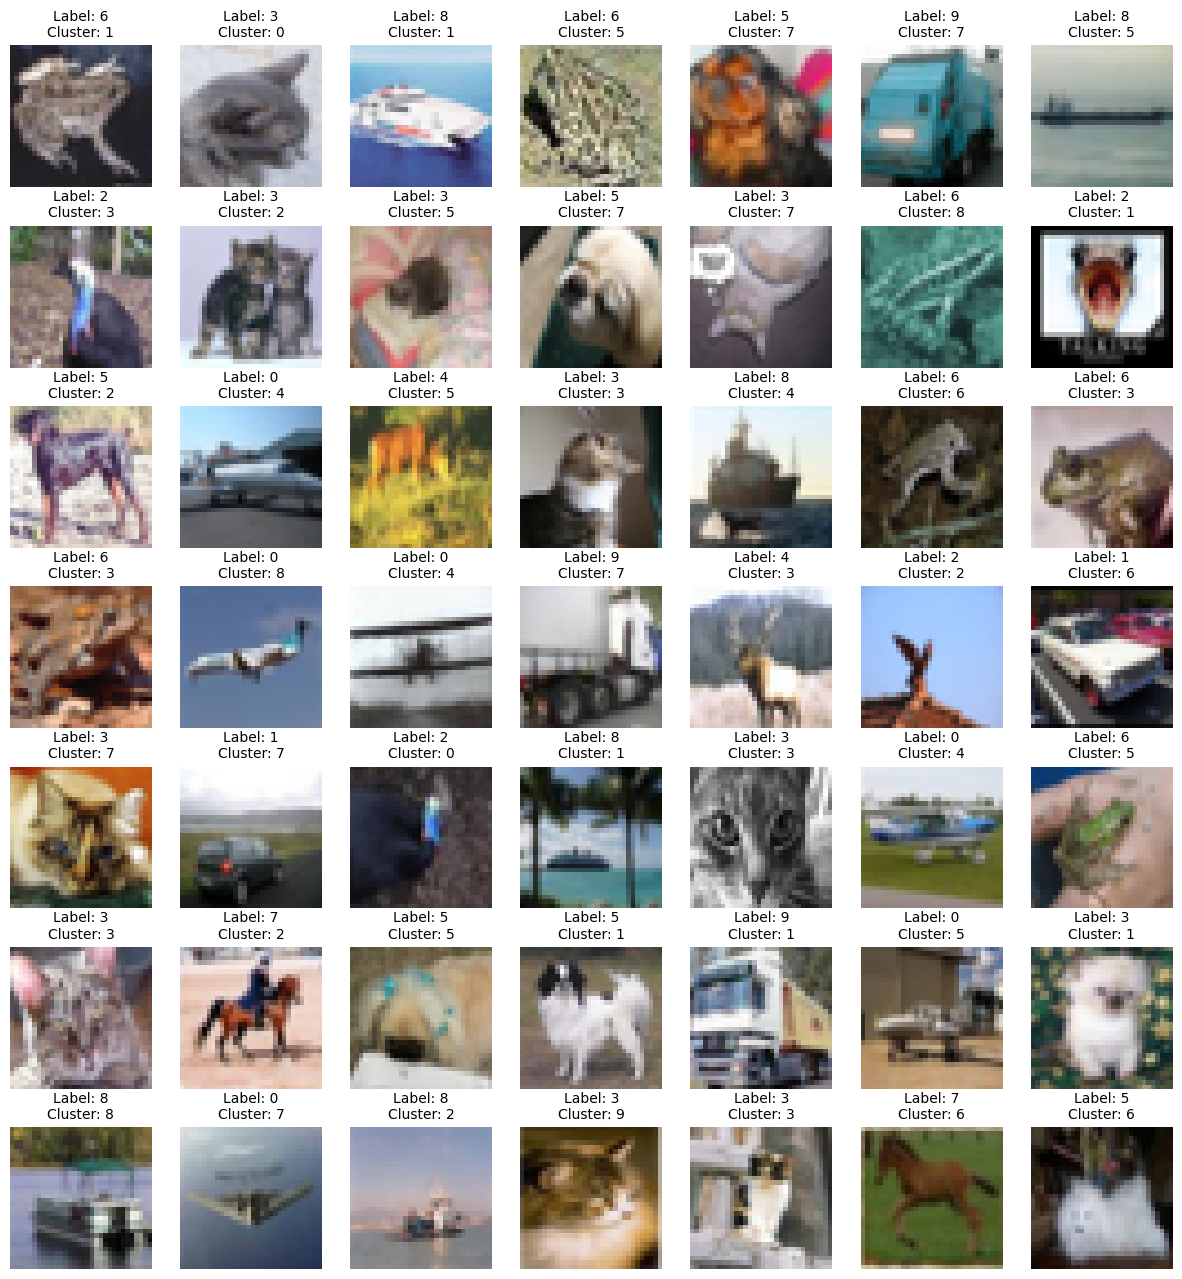

In [102]:
fig, axes = plt.subplots(7, 7, figsize=(15, 16))
for idx, (img, label) in enumerate(valid_subset):
    if idx >= 49:
        break
    
    if isinstance(img, torch.Tensor):
        img_array = img.permute(1, 2, 0).numpy()
        # Денормализовать если были нормализованы (опционально)
        # img_array = (img_array * 0.5 + 0.5)  # если использовали normalization
    else:
        img_array = img
    
    # Получить номер кластера для этого элемента
    cluster_id = clusters[idx]
    
    # Вывести изображение
    col = idx // 7
    row = idx % 7
    axes[row][col].imshow(img_array)
    axes[row][col].set_title(f'Label: {label}\nCluster: {cluster_id}', fontsize=10)
    axes[row][col].axis('off')

# Fake clusters

In [14]:
n = len(clusters)  # длина массива
fake_clusters = np.random.randint(0, 10, size=n)
clusters = fake_clusters

# Считывание архитектур

In [103]:
import os
import json
from pathlib import Path

In [104]:
folder_path = Path('./data/CIFAR10_acc/trained_models_archs_1')
# folder_path = Path('./data/CIFAR10_div/CIFAR10_div/architectures')
json_paths = [Path(x) for x in os.listdir(folder_path)]

In [105]:
valid_predictions_list = []
valid_acc_list = []
for json_path in json_paths:
    with open(folder_path / json_path, 'r') as file:
        data = json.load(file)

    valid_predictions_list += [data['valid_predictions']]
    valid_acc_list += [data['valid_accuracy']]
    architecture_list.append(data['architectures'])
        
    file_path = Path("data.json")

In [106]:
print(len(valid_acc_list))
print(np.array(valid_acc_list).mean(), np.array(valid_acc_list).std())

1000
0.7534777000000001 0.0071545950416498074


# Подсчет точности по кластерам

In [107]:
a = np.array(valid_labels)
b = np.array(valid_predictions_list[0])

In [108]:
print('Рассчитанная точность по ответам', (a == b).sum() / len(a))
print('Точность из json = ', valid_acc_list[0])

Рассчитанная точность по ответам 0.75695
Точность из json =  0.75695


In [109]:
cluster_acc_std_list = []
for i in range(len(valid_predictions_list)):
    preds = np.array(valid_predictions_list[i])
    is_correct = (preds == valid_labels)
    
    unique, counts = np.unique(clusters, return_counts=True)
    clusters_acc_list = []
    for cluster_id, count in zip(unique, counts):
        cluster_indexes = (clusters == cluster_id)
        cluster_results = is_correct[cluster_indexes]
        assert cluster_results.size == count
        cluster_acc = cluster_results.sum() / cluster_results.size
        clusters_acc_list.append(cluster_acc)
        # print(cluster_id, cluster_acc)
    cluster_acc_std_list.append(np.array(clusters_acc_list).std())

/tmp/ipykernel_6144/747761460.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


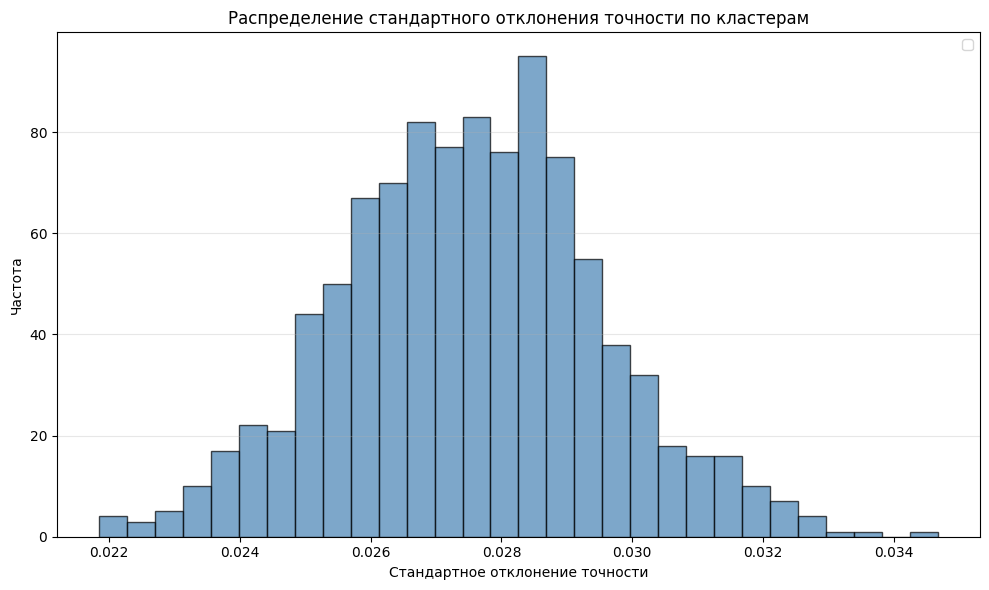

In [110]:
plt.figure(figsize=(10, 6))
plt.hist(cluster_acc_std_list, bins=30, color='steelblue', edgecolor='black', alpha=0.7)

plt.xlabel('Стандартное отклонение точности')
plt.ylabel('Частота')
plt.title('Распределение стандартного отклонения точности по кластерам')
plt.grid(axis='y', alpha=0.3)

# Добавить статистику на график
mean_std = np.mean(cluster_acc_std_list)
median_std = np.median(cluster_acc_std_list)

plt.legend()
plt.tight_layout()
plt.show()